## ICESat-2 SlideRule Download

This code is adapted from Sliderule Python example code. It is designed to calculate ATL06 elevations from ALT03 points and save those elevations as a CSV. 

Activate sliderule enviroment to run

In [1]:
import sys
import logging
import concurrent.futures
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
from shapely.geometry import Polygon, Point
from sliderule import icesat2
from sliderule import sliderule

## SlideRule Configuration

In [2]:
# Configure ICESat-2 API
icesat2.init("icesat2sliderule.org", False)

## Specify Region of Interest

#### 1. Make geojson from shapefile - if you have a geojson of the region skip to 2.

In [3]:
# Specify region of interest shapefile
shp = "RCEW/boundRCEW/RCEW-outline_WG84.shp"
shapefile = gpd.read_file(shp)
shapefile.to_file('RCEW/boundRCEW/boundRCEW_WGS84.geojson', driver='GeoJSON')
shapefile.crs is None

/Users/karinazikan/opt/anaconda3/envs/sliderule/lib/python3.8/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


False

In [4]:
## if shapefile.crs is None is false check the crs
shapefile.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
## if shapefile.crs is None is true run this section
crs = 'epsg:8826' # set the starting datum using the epsg code
icesat_crs = 4979 # epsg code for WGS84
shapefile = shapefile.set_crs(crs)
shapefile = shapefile.to_crs(icesat_crs) # transform to WGS84 
shapefile.to_file('DryCreek/boundDCEW/boundDCEW_WGS84.geojson', driver='GeoJSON')

In [ ]:
## if shapefile.crs is not WGS84 run this section
icesat_crs = 4979 # epsg code for WGS84
shapefile = shapefile.to_crs(icesat_crs) # transform to WGS84 
shapefile.to_file('DryCreek/boundDCEW/boundDCEW_WGS84.geojson', driver='GeoJSON')

#### 2. Read in geojson for Region of Interest

In [5]:
# Specify region of interest from geojson
poly_fn = 'RCEW/boundRCEW/boundRCEW_WGS84.geojson'
region = icesat2.toregion(poly_fn)["poly"] # symplify 
region

[{'lon': -116.799, 'lat': 43.06089},
 {'lon': -116.7954, 'lat': 43.06089},
 {'lon': -116.7481, 'lat': 43.06268},
 {'lon': -116.747, 'lat': 43.06295},
 {'lon': -116.7411, 'lat': 43.06456},
 {'lon': -116.7409, 'lat': 43.06469},
 {'lon': -116.7392, 'lat': 43.06591},
 {'lon': -116.7379, 'lat': 43.06712},
 {'lon': -116.7179, 'lat': 43.09706},
 {'lon': -116.7008, 'lat': 43.12889},
 {'lon': -116.6963, 'lat': 43.13834},
 {'lon': -116.696, 'lat': 43.13915},
 {'lon': -116.6922, 'lat': 43.15454},
 {'lon': -116.6881, 'lat': 43.22341},
 {'lon': -116.6881, 'lat': 43.22476},
 {'lon': -116.6947, 'lat': 43.24693},
 {'lon': -116.6954, 'lat': 43.24828},
 {'lon': -116.6958, 'lat': 43.24883},
 {'lon': -116.702, 'lat': 43.2564},
 {'lon': -116.7022, 'lat': 43.25654},
 {'lon': -116.7579, 'lat': 43.2872},
 {'lon': -116.7605, 'lat': 43.28828},
 {'lon': -116.7612, 'lat': 43.28856},
 {'lon': -116.8199, 'lat': 43.31163},
 {'lon': -116.8251, 'lat': 43.31298},
 {'lon': -116.8266, 'lat': 43.31218},
 {'lon': -116.8303

In [6]:
# Prepare coordinate lists for plotting the region of interest polygon
region_lon = [e["lon"] for e in region]
region_lat = [e["lat"] for e in region]

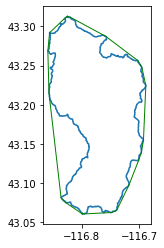

In [7]:
# Read geojson with geopandas
pregion = gpd.read_file(poly_fn)
map = pregion.plot(); # plot origonal boundery 
map.plot(region_lon, region_lat, linewidth=1, color='g'); # plot symplified region boundery for a sanity check

## Specify parameters for ATL06-SR (Sliderule) processing

In [8]:
# Build ATL06 Request #if remove "atl08_class", change icesat2.CNF_BACKGROUND to CNF_SURFACE_HIGH
parms = {
    "poly": region,
    "srt": icesat2.SRT_LAND,
    "atl08_class": "atl08_ground",
    "cnf": icesat2.CNF_BACKGROUND, 
    "ats": 20.0,
    "cnt": 10,
    "len": 40.0,
    "res": 20.0,
    "maxi": 6
}

## Calculate ATL06-SR Elevations from ATL03 Photons using SlideRule

In [9]:
# Latch Start Time
perf_start = time.perf_counter()

# Request ATL06 Data
atl06_sr = icesat2.atl06p(parms)

# Latch Stop Time
perf_stop = time.perf_counter()

# Display Statistics
perf_duration = perf_stop - perf_start
print("Completed in {:.3f} seconds of wall-clock time".format(perf_duration))
#print("Reference Ground Tracks: {}".format(atl06_sr["rgt"].unique()))
#print("Cycles: {}".format(atl06_sr["cycle"].unique()))
print("Received {} elevations".format(atl06_sr.shape[0]))

Completed in 28.680 seconds of wall-clock time
Received 72707 elevations


## Plot ATL06-SR Results

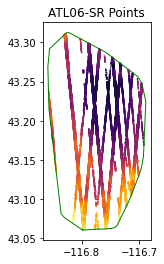

In [10]:
f, ax = plt.subplots()
ax.set_title("ATL06-SR Points")
ax.set_aspect('equal')
atl06_sr.plot(ax=ax, column='h_mean', cmap='inferno', s=0.1)
ax.plot(region_lon, region_lat, linewidth=1, color='g');

In [36]:
#Set utmzone code - utm zone 11:32611
utm_code = 'epsg:32611'

atl06_sr['Longitude'] = atl06_sr['geometry'].x
atl06_sr['Latitude'] = atl06_sr['geometry'].y
eastnorths = atl06_sr['geometry'].to_crs(utm_code)
atl06_sr['Easting'] = eastnorths.x
atl06_sr['Northing'] = eastnorths.y
atl06_sr.head()

,spot,gt,dh_fit_dx,h_sigma,pflags,segment_id,delta_time,cycle,rgt,dh_fit_dy,w_surface_window_final,n_fit_photons,distance,rms_misfit,h_mean,geometry,Latitude,Longitude,Easting,Northing
time,,,,,,,,,,,,,,,,,,,,
2018-11-26 21:09:05.940407724,6,10,-0.175885,0.216088,0,239687,2.850175e+07,1,905,0.0,4.526581,12,4.806611e+06,0.389217,1334.337122,POINT (-116.69469 43.18609),43.186091,-116.694691,524810.037093,4.781525e+06
2018-11-26 21:09:06.007120300,5,20,-0.260151,0.127058,0,239590,2.850175e+07,1,905,0.0,6.661973,14,4.804667e+06,0.455983,1423.868211,POINT (-116.69146 43.16874),43.168739,-116.691463,525079.458744,4.779599e+06
2018-11-26 21:09:06.009937656,5,20,-0.225228,0.092447,0,239591,2.850175e+07,1,905,0.0,5.775791,19,4.804687e+06,0.402960,1419.190789,POINT (-116.69149 43.16892),43.168918,-116.691486,525077.461122,4.779619e+06
2018-11-26 21:09:06.012749052,5,20,-0.105756,0.087934,0,239592,2.850175e+07,1,905,0.0,3.384974,14,4.804707e+06,0.327415,1415.312079,POINT (-116.69151 43.16910),43.169098,-116.691510,525075.448380,4.779639e+06
2018-11-26 21:09:06.021148344,5,20,-0.110525,0.073023,0,239595,2.850175e+07,1,905,0.0,3.000000,11,4.804767e+06,0.175884,1410.601461,POINT (-116.69158 43.16964),43.169636,-116.691582,525069.366480,4.779699e+06


## Write CSV

In [37]:
atl06_sr.to_csv("RCEW/RCEW-ICESat2-ATL06sr-atl08class.csv")

In [48]:
atl06_sr['time']

KeyError: 'time'